# Practica 3. Pareja 02: Daniel Mateo y Laura Sánchez.

In [1]:
# Cargamos todas las librerias necesarias para este Notebook.
import pandas as pd
import numpy as np
from Datos import Datos
from EstrategiaParticionado import *
from Clasificador import *
from ClasificadorNB import *
from ClasificadorAlgoritmoGenetico import *
from Distancias import *
import math
from pylab import *
import matplotlib.pyplot as plt

## APARTADO 1

En este apartado vamos a explicar cada uno de los puntos más importantes de los que se compone nuestra implementación del modelo de clasiciación de tipo Algoritmo Genético.

#### a) Generación de la población inicial

Para nuestro modelo de Algoritmo Genético, generamos la población inicial en la etapa del entrenamiento. Esto lo hacemos llamando al método genera_poblacion_inicial() que se encarga de crear cada uno de las soluciones o individuos de la población. 

En nuestro caso, se van a crear tam_poblacion individuos indicado por argumento. Cada uno de estos individuos van a poseer un número de reglas variable desde 1 a max_reglas, también pasado por argumento. 

La representación binaria de una regla depende del número de atributos que posea un dato del dataset, incluida la clase, y a su vez depende de los distintos valores que puede tomar cada atributo. En nuestro caso, la clase solo va a tomar la representación de 1 bit, al ser siempre binario. Por ejemplo:

Este dato de titanic.data posee los siguientes valores para sus atributos y es de clase 0: 2,male,3,0
Para representarlo, tenemos que ver qué posibles valores tiene cada atributo (en el código utilizamos el diccionario del dataset). El primer atributo posee 3 valores distintos, el segundo posee 2, y el tercero posee 16 valores distintos. Por lo tanto, la regla va a tener 3 bits para el primero, 2 bits para el segundo, 16 para el tercero y 1 para la clase, dando un total de 22 bits. Es decir, la longitud de una regla en titanic.data es de 22 bits. Entonces, este ejemplo se representaría de esta manera (el 3 es el noveno valor en el diccionario, ya que estos bits siguen el orden de diccionario): 010|01|0000000001000000|0

Cabe explicar que los datos van a poseer un solo bit a 1 por cada atributo, mientras que las reglas de la población inicial podrán tener distintas representaciones de bits aleatorias, pudiendo repetir bits a 1 en el mismo atributo. La semántica de las reglas equivale a un conjunto de operaciones lógicas OR dentro de cada atributo y un conjunto de operaciones AND entre el resultado de cada una de las OR, es decir, el conjunto de atributos de la regla. Esto cobrará sentido a la hora de ver si se activa la regla con un respectivo dato del dataset, de manera que una regla se considera activada si todo el conjunto de ORs son verdaderos al mismo tiempo, permitiendo leer la clase de la regla para luego ver si hay acierto o fallo.

Volviendo a la implementación, para cada individuo se genera un número de reglas aleatorio entre 1 y max_reglas. Y, a su vez, para cada regla, se generan (en el caso del titanic.data) 22 bits de manera aleatoria. La generación del individuo con reglas aleatorias se hace en el método genera_individuo_aleatorio(), llamado dentro del generador de la población inicial.

Tras esto, obtenemos la población inicial con tam_poblacion individuos aleatorios, listos para ser entrenados.

#### b) Selección de progenitores proporcional a fitness

Añadimos este apartado porque lo consideramos importante.

Una vez se ha generado la población inicial, entramos en un bucle por generaciones. Y, primero, se calculan los valores del fitness de cada uno de los individuos de la población. Esto lo hacemos contando el número de aciertos que tiene un individuo, gracias a sus reglas, sobre los datos de entrenamiento pasados. 

El método que mira si alguna de las reglas del individuo se activa se llama claseEnFuncionReglas(). Este método recorre los bits y los compara con el dato, para ver si se cumple la regla con la semántica ya explicada antes. Si es así, la clase indicada por esta regla se almacena. Si solo hay una, se devuelve esa. Si hay varias, se realiza una especie de voto por mayoría, eligiendo la moda más repetida (si se repiten por igual, devolvemos clase 1). Y, si no hay ninguna activada, se da por fallo.

Tras este cálculo, con los fitness, se llama al método ruleta_fitness() donde hallamos la probabilidad de selección de cada individuo a partir de su fitness. Esta selección simula una ruleta aleatoria que va sacando individuos de la población anterior a un array de progenitores, donde estos son sacados en función de esta probabilidad (cuanta mayor, más frecuencia de aparación entre los seleccionados). Se sacan en total tam_poblacion individuos.

#### c) Mecanismo de cruce implementado

En nuestro modelo hemos implementado dos tipos de cruce, que se pueden elegir por argumento mediante tipo_cruce. De tal manera que 1 corresponde al cruce uniforme y 2 corresponde al cruce en un punto.

A este método, cruce(), se le llama tras la selección de los progenitores proporcionales al fitness, ya que el cruce se hará entro estos progenitores seleccionados. Lo primero que hacemos es dividir la población entre los que van a sufrir el cruce y los que no, esto se hace con la probabilidad de cruce prob_cruce, pasada por argumento. Generamos un número aleatorio entre 0.0 y 1.0 para cada individuo, y si este número es menor que la probabilidad de cruce se cruzará ese individuo con el siguiente, ya que se cruzan de par de par, con el tipo de cruce elegido.  

El cruce uniforme, implementado en el método cruce_uniforme(), consiste en recorrer los bits de dos reglas elegidas al azar de cada uno de los dos individuos cruzados e ir intercambiando los bits. Con un número aleatorio 0 o 1, la regla del primer sucesor poseerá el bit del primer progenitor si es 1, o el bit del segundo progenitor si es 0. Y la regla del otro sucesor será lo contrario.

El cruce en un punto, implementado en el método cruce_un_punto(), consiste en elegir el punto donde se van a cortar ambas reglas (elegidas de la misma forma que en el cruce uniforme) de forma aleatoria generando un número entre 1 y el tamaño de la regla - 1. La regla del primer sucesor estará formada por la parte izquierda del primer progenitor y la derecha del segundo, y el segundo sucesor por las partes restantes.


#### d) Mecanismo de mutación implementado

Tras el cruce, pasamos a mutar algunos individuos de la población mediante el método mutacion(). Igual que en el cruce, primero dividimos la población entre aquellos que van a sufrir mutación y los que no, sufren mutación si el número aleatorio generado es menor que la probabilidad de mutación, pasado por argumento prob_mutacion. Hemos implementado 3 tipos de mutación diferentes: quitar regla, añadir regla y bit-flip.  

El primero consiste en eliminar una de las reglas de manera aleatoria del individuo (si posee más de una). El segundo consiste en lo contrario, crear una regla aleatoria nueva y añadirsela al individuo (si no tiene ya el máximo de reglas). Y, el bit-flip consiste en elegir un bit de una de las reglas del individuo aleatoriamente y sustituirlo por su contrario.

El tipo de mutación se realiza de forma aleatoria, teniendo en cuenta las excepciones mencionadas anteriormente.

#### e) Elitismo

Otro apartado que hemos considerado crucial, por lo que lo hemos incluido.

Los mejores individuos, correspondientes al 5% de la población, es decir, los que tengan los dos mejores fitness sobrevivirán para pasar a la siguiente generación. Esta selección la hacemos antes de realizar la selección de progenitores, y estos individuos los volvemos a añadir en la población en el momento de la supervivencia. 

Sin embargo, nos aseguramos de que al introducirlos no destruimos los dos mejores nuevos individuos resultantes del cruce y la mutación, ni a los dos peores, para mantener la variabilidad de la evolución de las generaciones.

Este elitismo garantiza que los mejores individuos de cada generación solo pueden mejorar o mantenerse, pero no empeorar.

#### f) Mecanismo de clasificación implementado

Tras todo lo anterior, cuando se obtiene la última generación, se busca el mejor individuo entre todos los individuos finales y se almacena para la clasificación.

En la clasificación, para cada dato del datostest comprobamos qué reglas se activan del individuo. Si se activa una regla, devolvemos la clase de esa regla; si se activan varias, devolvemos la clase mayoritaria entre todas ellas; y, si no se activa ninguna regla, devolvemos clase 1.  

## APARTADO 2

En este apartado, vamos a observar los resultados de la clasificación para cada uno de los dos conjuntos de prueba y veremos cuál es la combinación de individuos/generaciones con la que se consigue el mejor resultado. Además, se analizará el significado del conjunto de reglas correspondiente al mejor individuo.

Primero, tenemos que cargar los dos datasets dados, que son titanic.data y tic-tac-toe.data.

In [11]:
# Dataset de titanic.data.
dataset1 = Datos("./titanic.data")
#print(dataset1.nominalAtributos)
print(dataset1.diccionario)
#print(dataset1.datos)

# Dataset de tic-tac-toe.data.
dataset2 = Datos("./tic-tac-toe.data")
#print(dataset2.nominalAtributos)
print(dataset2.diccionario)
#print(dataset2.datos)

{'Pclass': {'1': 0, '2': 1, '3': 2}, 'Sex': {'female': 0, 'male': 1}, 'Age': {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15}, 'Class': {0: 0, 1: 1}}
{'TLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'TMidSq': {'b': 0, 'o': 1, 'x': 2}, 'TRightSq': {'b': 0, 'o': 1, 'x': 2}, 'MLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'MMidSq': {'b': 0, 'o': 1, 'x': 2}, 'MRightSq': {'b': 0, 'o': 1, 'x': 2}, 'BLeftSq': {'b': 0, 'o': 1, 'x': 2}, 'BMidSq': {'b': 0, 'o': 1, 'x': 2}, 'BRightSq': {'b': 0, 'o': 1, 'x': 2}, 'Class': {'negative': 0, 'positive': 1}}


Además, creamos la instancia de la estrategia de particionado, que va a ser una solo para todas las pruebas de esta práctica, siendo Validación Cruzada con solo 2 divisiones del dataset al 50%, y dos particiones (equivalente a la Validación Simple).

In [3]:
# Validación cruzada de 2 o Validación simple de 1
vc = ValidacionCruzada(2) 

A continuación, creamos las instancias correspondientes a cada uno de los algoritmos genéticos que vamos a probar, con distintos valores para las generaciones (100-200) y para el tamaño de la población (50-150). En cuanto al resto, hemos decidido aplicar una probabilidad de cruce del 75%, una probabilidad de mutación del 10%, los individuos poseen como máximo 10 reglas y vamos a utilizar solo el cruce en un punto (ya que creemos que es mejor en este problema).

In [4]:
# Creamos los 4 tipos de clasificadores que vamos a probar en cada dataset

# 100 generaciones y 50 individuos
c100_50 = ClasificadorAlgoritmoGenetico(100, 50, 10, 2, 0.75, 0.1)
# 200 generaciones y 50 individuos
c200_50 = ClasificadorAlgoritmoGenetico(200, 50, 10, 2, 0.75, 0.1)
# 100 generaciones y 150 individuos
c100_150 = ClasificadorAlgoritmoGenetico(100, 150, 10, 2, 0.75, 0.1)
# 200 generaciones y 150 individuos
c200_150 = ClasificadorAlgoritmoGenetico(200, 150, 10, 2, 0.75, 0.1)

Como nos van a interesar los resultados de las tasas de error, inicializamos cuatro diccionarios. En uno de ellos almacenaremos cada media de tasas de error correspondiente a las dos validaciones de cada modelo por cada dataset existente. En los otros dos, guardaremos la evolución de medias del fitness del entrenamiento de cada modelo por cada dataset, y en el otro la evolución del mejor fitness. Y, en el último, guardamos los mejores individuos para más adelante.

In [5]:
# Creamos el diccionario para guardar la media de los scores obtenidos con cada validación 
dicc_scores = {}
dicc_scores["100_50"] = []
dicc_scores["200_50"] = []
dicc_scores["100_150"] = []
dicc_scores["200_150"] = []

# Creamos otros dos diccionarios para almacenar los fitness medios y mejores de cada generacion
dicc_fitness_medios = {}
dicc_fitness_mejores = {}
dicc_fitness_medios["100_50"] = []
dicc_fitness_medios["200_50"] = []
dicc_fitness_medios["100_150"] = []
dicc_fitness_medios["200_150"] = []
dicc_fitness_mejores["100_50"] = []
dicc_fitness_mejores["200_50"] = []
dicc_fitness_mejores["100_150"] = []
dicc_fitness_mejores["200_150"] = []

# Creamos otros diccionario para almacenar los mejores individuos de cada validación
dicc_mejores_individuos = {}
dicc_mejores_individuos["100_50"] = []
dicc_mejores_individuos["200_50"] = []
dicc_mejores_individuos["100_150"] = []
dicc_mejores_individuos["200_150"] = []

Una vez están los diccionarios creados, realizamos las distintas validaciones ya indicadas, almacenando todo lo dicho en sus respectivos diccionarios.

Hemos ejecutado cada una de las combinaciones posibles para el modelo de esta práctica, por cada dataset. Esto lo hicimos aparte y hemos capturado los resultados en el archivo practica3_apartado2.html, y en él se ha obtenido que la mejor combinación ha sido la de 100 generaciones y 50 individuos en ambos datasets. Por lo tanto, en este notebook solo vamos a ejecutar esta combinación para responder a las demás preguntas.

Hemos comentado esta prueba entre ''' para que pueda verlo en este notebook, al igual que el fragmento de código que identificaba al mejor modelo de los probados.

In [6]:
# Pruebas para el dataset titanic.data

errores = c100_50.validacion(vc, dataset1, c100_50, None)
media_errores = (errores[0]+errores[1]) / 2
dicc_scores["100_50"].append(media_errores)
dicc_fitness_medios["100_50"].append(c100_50.fitness_medios_gens)
dicc_fitness_mejores["100_50"].append(c100_50.fitness_best_gens)
dicc_mejores_individuos["100_50"].append(c100_50.mejor_individuo)
ag_roc_titanic = c100_50.tasas_confusion

'''
errores = c200_50.validacion(vc, dataset1, c200_50, None)
media_errores = (errores[0]+errores[1]) / 2
dicc_scores["200_50"].append(media_errores)
dicc_fitness_medios["200_50"].append(c200_50.fitness_medios_gens)
dicc_fitness_mejores["200_50"].append(c200_50.fitness_best_gens)
dicc_mejores_individuos["200_50"].append(c200_50.mejor_individuo)


errores = c100_150.validacion(vc, dataset1, c100_150, None)
media_errores = (errores[0]+errores[1]) / 2
dicc_scores["100_150"].append(media_errores)
dicc_fitness_medios["100_150"].append(c100_150.fitness_medios_gens)
dicc_fitness_mejores["100_150"].append(c100_150.fitness_best_gens)
dicc_mejores_individuos["100_150"].append(c100_150.mejor_individuo)


errores = c200_150.validacion(vc, dataset1, c200_150, None)
media_errores = (errores[0]+errores[1]) / 2
dicc_scores["200_150"].append(media_errores)
dicc_fitness_medios["200_150"].append(c200_150.fitness_medios_gens)
dicc_fitness_mejores["200_150"].append(c200_150.fitness_best_gens)
dicc_mejores_individuos["200_150"].append(c200_150.mejor_individuo)'''


# Pruebas para el dataset tic-tac-toe.data

errores = c100_50.validacion(vc, dataset2, c100_50, None)
media_errores = (errores[0]+errores[1]) / 2
dicc_scores["100_50"].append(media_errores)
dicc_fitness_medios["100_50"].append(c100_50.fitness_medios_gens)
dicc_fitness_mejores["100_50"].append(c100_50.fitness_best_gens)
dicc_mejores_individuos["100_50"].append(c100_50.mejor_individuo)
ag_roc_ttt = c100_50.tasas_confusion

'''
errores = c200_50.validacion(vc, dataset2, c200_50, None)
media_errores = (errores[0]+errores[1]) / 2
dicc_scores["200_50"].append(media_errores)
dicc_fitness_medios["200_50"].append(c200_50.fitness_medios_gens)
dicc_fitness_mejores["200_50"].append(c200_50.fitness_best_gens)
dicc_mejores_individuos["200_50"].append(c200_50.mejor_individuo)


errores = c100_150.validacion(vc, dataset2, c100_150, None)
media_errores = (errores[0]+errores[1]) / 2
dicc_scores["100_150"].append(media_errores)
dicc_fitness_medios["100_150"].append(c100_150.fitness_medios_gens)
dicc_fitness_mejores["100_150"].append(c100_150.fitness_best_gens)
dicc_mejores_individuos["100_150"].append(c100_50.mejor_individuo)


errores = c200_150.validacion(vc, dataset2, c200_150, None)
media_errores = (errores[0]+errores[1]) / 2
dicc_scores["200_150"].append(media_errores)
dicc_fitness_medios["200_150"].append(c200_150.fitness_medios_gens)
dicc_fitness_mejores["200_150"].append(c200_150.fitness_best_gens)
dicc_mejores_individuos["200_150"].append(c200_150.mejor_individuo)'''

Fitness del mejor individuo: 415
Fitness del mejor individuo: 411
Fitness del mejor individuo: 282
Fitness del mejor individuo: 313


'\nerrores = c200_50.validacion(vc, dataset2, c200_50, None)\nmedia_errores = (errores[0]+errores[1]) / 2\ndicc_scores["200_50"].append(media_errores)\ndicc_fitness_medios["200_50"].append(c200_50.fitness_medios_gens)\ndicc_fitness_mejores["200_50"].append(c200_50.fitness_best_gens)\ndicc_mejores_individuos["200_50"].append(c200_50.mejor_individuo)\n\n\nerrores = c100_150.validacion(vc, dataset2, c100_150, None)\nmedia_errores = (errores[0]+errores[1]) / 2\ndicc_scores["100_150"].append(media_errores)\ndicc_fitness_medios["100_150"].append(c100_150.fitness_medios_gens)\ndicc_fitness_mejores["100_150"].append(c100_150.fitness_best_gens)\ndicc_mejores_individuos["100_150"].append(c100_50.mejor_individuo)\n\n\nerrores = c200_150.validacion(vc, dataset2, c200_150, None)\nmedia_errores = (errores[0]+errores[1]) / 2\ndicc_scores["200_150"].append(media_errores)\ndicc_fitness_medios["200_150"].append(c200_150.fitness_medios_gens)\ndicc_fitness_mejores["200_150"].append(c200_150.fitness_best_g

Y, tras obtener los resultados, analizamos cual es el mejor para cada dataset y lo indicamos.

In [7]:
'''
# Comprobamos cual ha sido el mejor clasificador de los anteriores para cada dataset

mejor_score1 = 1
mejor_score2 = 1
mejor_ind1 = []
mejor_ind2 = []
array_clasificadores = ["100_50","200_50","100_150", "200_150"]

# Para el dataset titanic
for c in array_clasificadores:
    if dicc_scores[c][0] < mejor_score1:
        mejor_score1 = dicc_scores[c][0]
        mejor_clasificador1 = c.split('_')
        mejor_ind1 = dicc_mejores_individuos[c][0]

# Para el dataset tic-tac-toe
for c in array_clasificadores:
    if dicc_scores[c][1] < mejor_score2:
        mejor_score2 = dicc_scores[c][1]
        mejor_clasificador2 = c.split('_')
        mejor_ind2 = dicc_mejores_individuos[c][1]
        
print("Para el dataset titanic.data el clasificador que ha obtenido mejor score medio ha sido:\n")
print("Generaciones: " + str(mejor_clasificador1[0]))
print("Tamanio poblacion: " + str(mejor_clasificador1[1]))
print("Mejor individuo: ")
print(mejor_ind1)

print("\n")

print("Para el dataset tic-tac-toe.data el clasificador que ha obtenido mejor score medio ha sido:\n")
print("Generaciones: " + str(mejor_clasificador1[0]))
print("Tamanio poblacion: " + str(mejor_clasificador1[1]))
print("Mejor individuo: ")
print(mejor_ind2)'''

print("Para el dataset titanic.data el clasificador que ha obtenido mejor score medio ha sido:\n")
print("Generaciones: 100")
print("Tamanio poblacion: 50")
print("Media de tasas de error: " + str(dicc_scores["100_50"][0]))
print("Mejor individuo: ")
print(dicc_mejores_individuos["100_50"][0])

print("\n")

print("Para el dataset tic-tac-toe.data el clasificador que ha obtenido mejor score medio ha sido:\n")
print("Generaciones: 100")
print("Tamanio poblacion: 50")
print("Media de tasas de error: " + str(dicc_scores["100_50"][1]))
print("Mejor individuo: ")
print(dicc_mejores_individuos["100_50"][1])

Para el dataset titanic.data el clasificador que ha obtenido mejor score medio ha sido:

Generaciones: 100
Tamanio poblacion: 50
Media de tasas de error: 0.2323135755258126
Mejor individuo: 
[[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], [1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0], [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1], [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1], [1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0], [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1], [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1]]


Para el dataset tic-tac-toe.data el clasificador que ha obtenido mejor score medio ha sido:

Generaciones: 100
Tamanio poblacion: 50
Media de tasas de error: 0.3423799582463466
Mejor individuo: 

Respecto a la media de las tasas de error obtenidas en ambos datasets, vemos que para el dataset Titanic obtenemos un valor de 23% y para el dataset Tic-tac-toe obtenemos un valor de 34%. Como vemos, la media de tasa de error es menor para el dataset Titanic que para el de Tic-tac-toe, esto se puede deber a que la distribución de los datos de Tic-tac-toe no es la más adecuada para este tipo de clasificadores. Es posible que el mejor individuo tras entrenar al clasificador no llegue a simular correctamente las relaciones complejas entre los atributos de este dataset.


Ahora, vamos a analizar los mejores individuos resultantes de cada entrenamiento (los que están impresos) y una de sus reglas.

- El individuo obtenido en Titanic posee un total de 9 reglas, donde 4 reglas predicen la clase 0 y 5 reglas predicen la clase 1. Por lo tanto, a la hora de clasificar, se posee una variedad correcta de reglas para predecir de manera precisa los datos del Test, al contemplar diferentes situaciones para cada clase.

- Por ejemplo, la regla \[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0\] se activará cuando el atributo PClass tenga o el valor 1 o el valor 3; el atributo Sex tenga cualquier valor; y el atributo Age tenga alguno de estos valores: 0, 11, 14, 2, 3, 7 o 9. Al activarse, como se ve, indica la clase 0.

- El individuo obtenido en Tic-Tac-Toe posee 7 reglas, donde todas ellas predicen la clase 1. Por lo tanto, a la hora de clasificar, no existe una variedad correcta de reglas para predecir, por lo que todas las predicciones de este individuo solo van a dar clase 1, lo cuál no es apropiado. Sin embargo, creemos que ha sido simplemente culpa de la aleatoriedad, ya que en la prueba del html se puede ver que el individuo mejor del Tic-Tac-Toe poseía 10 reglas, donde tres predicen clase 0, por lo que sí posee variedad.

- Por ejemplo, la regla \[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1\] se activará cuando el atributo TLeftSq se activa en cualquier valor; el atributo TMidSq no se va activar al ser todo 0; el atributo TRightSq se activa cuando vale x u o; el atributo MLeftSq cuando vale b u o; el atributo MMidSq cuando vale b; el atributo MRightSq cuando vale x u o; el atributo BLeftSq cuando x u o; el atributo BMidSq con cualquier valor; y el atributo BRightSq con cualquier valor. Si se activara, daría clase 1, sin embargo, vemos que es una regla que nunca se va a activar al poseer falso siempre el atributo TMidSq. Este tipo de reglas es normal que salgan, ya que todo es aleatorio; simplemente no ayudan en la predicción.

### APARTADO 3

En este apartado, analizamos la importancia de cada uno de los parámetros del modelo genético.

- Respecto al número de reglas, pensamos que cuantas más reglas mejor será el clasificador. Esto es debido a que permite a sus individuos poseer una mayor cantidad de reglas. Si nos centramos en el mejor individuo, este será más completo y polivalente, ya que podrá predecir de manera más precisa y consensada las dos clases. En cambio,  si un individuo tiene pocas reglas no puede adaptarse a muchas situaciones y tendrá predicciones menos precisas. Se puede observar en las pruebas del html y en los individuos resultantes de la actual ejecución, que los mejores individuos (mejores fitness) poseen un número de reglas cercano al máximo, que en nuestro caso es 10.


- En cuanto al tamaño de la población, podemos ver en el fichero html que los fitness para cada dataset son más o menos iguales para 150 individuos que para 50 individuos si mantenemos el mismo número de generaciones. Creemos que esto es debido a que al ser todo un proceso completamente aleatorio, el hecho de tener una población más grande permite tener una mayor variedad de soluciones, pero no implica de manera directa obtener el mejor resultado posible.


- Pensamos que el parámetro del número de generaciones es el más importante a la hora de obtener resultados. Como vemos en el  fichero html, obtenemos mejores fitness cuando el número de generaciones es mayor, 200, que cuando es menor, 100, y el tamaño de la población es el mismo en ambos casos. Esto se debe a que cuantas más veces se itere en el entrenamiento, los individuos van a tener más oportunidades de evolucionar y mejorar sus fitness. Sin embargo, esto puede llevar a sobreajuste y que el mejor individuo final, aunque tenga un fitness elevado, no realice tan buenas predicciones en validación respecto a otro individuo de una generación menor (esto creemos que es lo que ha ocurrido en la prueba, ya que nos sale una menor tasa de error media con el modelo de 100 generaciones que con el modelo de 200).


- Para las pruebas hemos utilizado una tasa de cruce del 75% siempre. Sabemos que este parámetro, cuanto mayor sea, más  individuos de la generación se cruzarán entre sí para dar nuevos sucesores. Por lo tanto, si se cruzan progenitores de buen fitness, lo normal es que obtengamos sucesores mejores que sus padres. Y, si comparamos tipos de cruce, como el uniforme y el cruce en un punto, pensamos que el segundo es mejor en este problema, ya que no destruye estructuras bien formadas de los buenos progenitores. En conclusión, este parámetro es el que permite la evolución en el modelo (explotación de soluciones).


- Nuestra tasa de mutación tiene un valor del 10% siempre. Esta tasa no puede tener un valor muy elevado, ya que puede que se  pierda un bit o una regla obtenida importante, afectando a los mejores fitness (empeorandolos en ese caso). La mutación nos permite explorar soluciones que no se habían considerado antes y puede permitirnos, después en el cruce, llegar hasta el mejor individuo.

### APARTADO 4

En este apartado, vamos a dibujar gráficamente la evolución de los mejores fitness y los fitness medios de cada generación para los modelos anteriores, dos gráficas por cada partición del dataset.

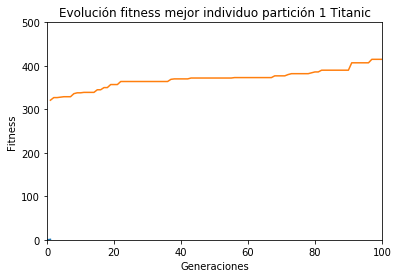

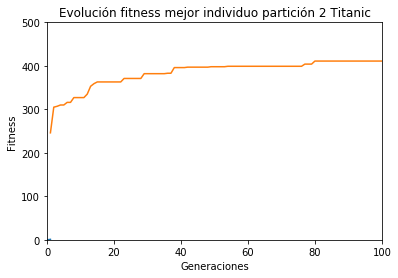

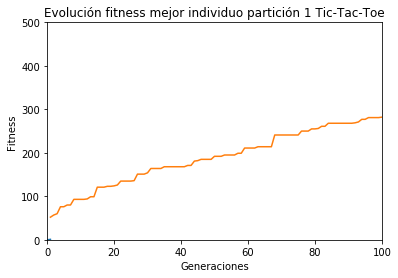

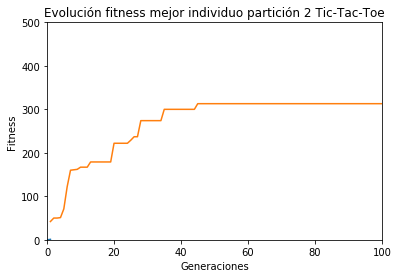

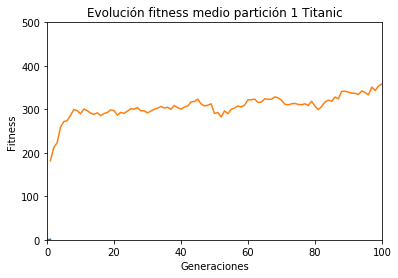

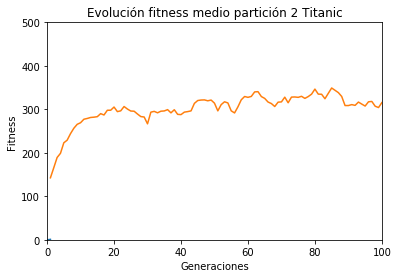

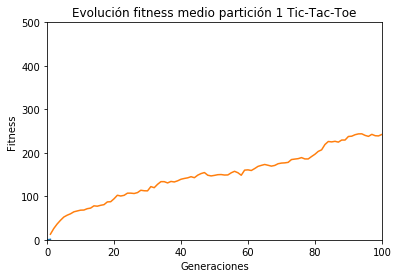

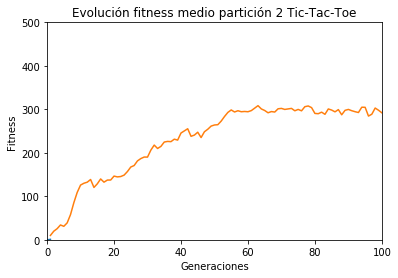

In [8]:
x = [*range(1, 101, 1)] 

# FITNESS MEJOR INDIVIDUO
y = dicc_fitness_mejores["100_50"][0][0]

title('Evolución fitness mejor individuo partición 1 Titanic') 
xlabel('Generaciones')      
ylabel('Fitness')    
plt.plot([0, 1], [0, 1])
plt.xlim([0, 100])
plt.ylim([0, 500])

plot(x, y)                  
show()

y = dicc_fitness_mejores["100_50"][0][1]

title('Evolución fitness mejor individuo partición 2 Titanic') 
xlabel('Generaciones')      
ylabel('Fitness')    
plt.plot([0, 1], [0, 1])
plt.xlim([0, 100])
plt.ylim([0, 500])

plot(x, y)                  
show()

y = dicc_fitness_mejores["100_50"][1][0]

title('Evolución fitness mejor individuo partición 1 Tic-Tac-Toe') 
xlabel('Generaciones')      
ylabel('Fitness')    
plt.plot([0, 1], [0, 1])
plt.xlim([0, 100])
plt.ylim([0, 500])

plot(x, y)                  
show()

y = dicc_fitness_mejores["100_50"][1][1]

title('Evolución fitness mejor individuo partición 2 Tic-Tac-Toe') 
xlabel('Generaciones')      
ylabel('Fitness')    
plt.plot([0, 1], [0, 1])
plt.xlim([0, 100])
plt.ylim([0, 500])

plot(x, y)                  
show()

# FITNESS MEDIO POBLACION
y = dicc_fitness_medios["100_50"][0][0]

title('Evolución fitness medio partición 1 Titanic') 
xlabel('Generaciones')      
ylabel('Fitness')    
plt.plot([0, 1], [0, 1])
plt.xlim([0, 100])
plt.ylim([0, 500])

plot(x, y)                  
show()

y = dicc_fitness_medios["100_50"][0][1]

title('Evolución fitness medio partición 2 Titanic') 
xlabel('Generaciones')      
ylabel('Fitness')    
plt.plot([0, 1], [0, 1])
plt.xlim([0, 100])
plt.ylim([0, 500])

plot(x, y)                  
show()

y = dicc_fitness_medios["100_50"][1][0]

title('Evolución fitness medio partición 1 Tic-Tac-Toe') 
xlabel('Generaciones')      
ylabel('Fitness')    
plt.plot([0, 1], [0, 1])
plt.xlim([0, 100])
plt.ylim([0, 500])

plot(x, y)                  
show()

y = dicc_fitness_medios["100_50"][1][1]

title('Evolución fitness medio partición 2 Tic-Tac-Toe') 
xlabel('Generaciones')      
ylabel('Fitness')    
plt.plot([0, 1], [0, 1])
plt.xlim([0, 100])
plt.ylim([0, 500])

plot(x, y)                  
show()

Podemos sacar en claro muchas cosas de las gráficas anteriores:

- Primero, podemos ver que el mejor fitness de cada generación, en ambos datasets, siempre es mayor o igual al fitness del mejor individuo de la generación anterior. Esto se debe al efecto causado por el elitismo, que mantiene siempre el 5% de los mejores individuos de cada generación como supervivientes para la siguiente. Por lo tanto, las gráficas son crecientes con escalones, aumentando el fitness a medida que aumenta la generación.


- Respecto a los fitness medios, podemos ver que no tiene porqué mejorar en cada generación, ya que se pueden observar pequeñas bajadas (picos) por la aleatoriedad del algoritmo. Pero, en general, se refleja en la gráfica una subida progresiva del valor medio del fitness a medida que aumentan las generaciones, ya que también aumenta el número de individuos mejores.


- Si comparamos ambos tipos de gráficas, se obtiene una especie de gráfica asintótica creciente que se acaba estabilizando al pasar por encima, más o menos, de la mitad de las generaciones.

### APARTADO 5

En este último apartado, vamos a realizar el análisis ROC de los resultados del algoritmo genético y compararlo con los resultados de nuestro Naive Bayes.

Primero, creamos el clasificador de Naive Bayes (con Laplace) y lo entrenamos para ambos datasets, y vemos sus resultados.

In [9]:
# Clasificador de NB con Laplace
nb_laplace = ClasificadorNaiveBayes(True)

# Dataset Titanic
tasas_error = nb_laplace.validacion(vc, dataset1, nb_laplace, None)
media_error = (tasas_error[0]+tasas_error[1])/2
nb_roc_titanic = nb_laplace.tasas_confusion

print("NB en Titanic media: " + str(media_error))

#Dataset Tic-Tac-Toe
tasas_error = nb_laplace.validacion(vc, dataset2, nb_laplace, None)
media_error = (tasas_error[0]+tasas_error[1])/2
nb_roc_ttt = nb_laplace.tasas_confusion

print("NB en Tic-Tac-Toe media: " + str(media_error))

NB en Titanic media: 0.22275334608030595
NB en Tic-Tac-Toe media: 0.2985386221294363


Podemos ver que Naive Bayes se comporta bien con ambos datasets, de manera parecida al algoritmo genético. Aunque se puede decir que es un mejor modelo para el dataset de Tic-Tac-Toe, ya que su error medio es menor, un 29%.

A continuación, representamos las gráficas del análisis ROC juntado ambos clasificadores para cada dataset. Se obtiene lo siguiente:

ROC sobre Titanic: 
Algoritmo Genético ==> FPR = 0.17207792207792208 TPR = 0.6372093023255814
NB ==> FPR = 0.1853035143769968 TPR = 0.7095238095238096


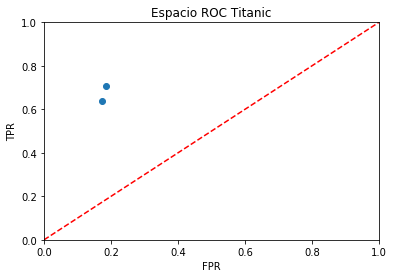

ROC sobre Tic-Tac-Toe: 
Algoritmo Genético ==> FPR = 1.0 TPR = 1.0
NB ==> FPR = 0.5454545454545454 TPR = 0.8153846153846154


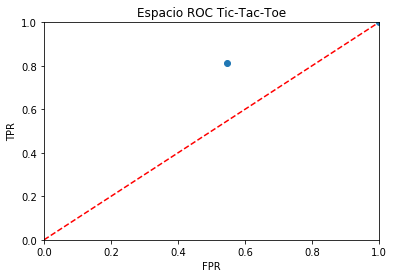

In [10]:
## Espacio ROC usando los clasificadores NB y Algoritmo Genético sobre el dataset de Titanic.
x = []
x.append(ag_roc_titanic[2])
x.append(nb_roc_titanic[2])

y = []
y.append(ag_roc_titanic[0])
y.append(nb_roc_titanic[0])

print("ROC sobre Titanic: ")
print("Algoritmo Genético ==> FPR = " + str(x[0]) + " TPR = " + str(y[0]))
print("NB ==> FPR = " + str(x[1]) + " TPR = " + str(y[1]))

title('Espacio ROC Titanic') 
xlabel('FPR')      
ylabel('TPR')    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plot(x, y, 'o')                  
show()

## Espacio ROC usando los clasificadores NB y Algoritmo Genético sobre el dataset de Tic-Tac-Toe.
x = []
x.append(ag_roc_ttt[2])
x.append(nb_roc_ttt[2])

y = []
y.append(ag_roc_ttt[0])
y.append(nb_roc_ttt[0])

print("ROC sobre Tic-Tac-Toe: ")
print("Algoritmo Genético ==> FPR = " + str(x[0]) + " TPR = " + str(y[0]))
print("NB ==> FPR = " + str(x[1]) + " TPR = " + str(y[1]))

title('Espacio ROC Tic-Tac-Toe') 
xlabel('FPR')      
ylabel('TPR')    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plot(x, y, 'o')                  
show()

Como podemos observar, los algoritmos anteriores realizan buenas predicciones en el dataset Titanic al poseer el punto por encima de la bisectriz del espacio ROC, que significa predecir más verdaderos que falsos. En cambio, en el dataset de Tic-Tac-Toe se ve que NB predice de manera correcta por lo que se acaba de explicar, pero el Algoritmo Genético se queda en la esquina superior derecha de la gráfica, y sobre la bisectriz. Esto es debido, a como hemos visto antes, el mejor individuo resultante ha dado la casualidad de que solo predice clase 1.

Por lo tanto, si comparamos ambos modelos de clasificación, llegamos a la conclusión de que en Titanic se comportan de igual manera, aunque Naive Bayes se encuentra un poco más cerca del desempeño óptimo (cerca de la esquina superior izquierda, donde todas las predicciones han sido verdaderas). En Tic-Tac-Toe, ya hemos visto que Naive Bayes es mejor que el Algoritmo Genético (en general, mirando también el error medio, ya que en este caso no beneficia el resultado al espacio ROC).

En conclusión, después de haber realizado este estudio, pensamos que elegiríamos el modelo de Naive Bayes antes que el Algoritmo Genético. Básicamente, debido a que llegamos a resultados parecidos en ambos modelos, pero el tiempo de ejecución del Algoritmo Genético es bastante más alto. Además, como se ha visto, puede que el Algoritmo Genético no llegue a crear un buen individuo final, es decir, poco generalizado (no interesa).